http://pythonhosted.org/pymeteo/#plotting
https://github.com/cwebster2/pyMeteo

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math


import pandas as pd
import metpy.calc as mpcalc
from metpy.units import units


import pymeteo.interp as interp
import pymeteo.thermo as thermo
import pymeteo.skewt as skewt
%matplotlib inline 

In [118]:
### Getting Data
days = [19, 20, 21, 22, 23, 25, 26, 27, 28]
col_names = ['PRES', 'HGHT', 'TEMP', 'DWPT', 'MIXR', 'DRCT', 'SKNT', 'THTA']

df = pd.read_csv('../Soundings_Stavanger/20161219_00Z.csv' ,\
                    sep = ';',header=0,usecols=[0, 1, 2, 3, 5, 6, 7, 8], names=col_names)


df['u_wind'], df['v_wind'] = mpcalc.get_wind_components(np.asarray(df['SKNT']),np.deg2rad(np.asarray(df['DRCT'])))

# Drop any rows with all NaN values for T, Td, winds, ..
#df = df.dropna(subset=('TEMP', 'DWPT', 'MIXR', 'DRCT', 'SKNT', 'THTA',
 #                      'u_wind', 'v_wind'), how='all').reset_index(drop=True)



In [119]:
# prepare 1D arrays height (z), pressure (p), potential temperature (th), 
# water vapor mixing ratio (qv), winds (u and v) all of the same length.

#z = np.asarray(df['HGHT'])
#p = np.asarray(df['PRES'])
#th = np.asarray(df['THTA'])
#qv = np.asarray(df['MIXR'])
#T = np.asarray(df['TEMP'])
#Td = np.asarray(df['DWPT'])

# We will pull the data out of the example dataset into individual variables and
# assign units.

z = np.asarray(df['HGHT'])
p = np.asarray(df['PRES'])
th = np.asarray(df['THTA'])
qv = np.asarray(df['MIXR'])
T = np.asarray(df['TEMP'])
Td = np.asarray(df['DWPT'])
wind_speed = np.asarray(df['SKNT'])
wind_dir = np.deg2rad(np.asarray(df['DRCT']))
u, v = mpcalc.get_wind_components(wind_speed, wind_dir)
p = p*100

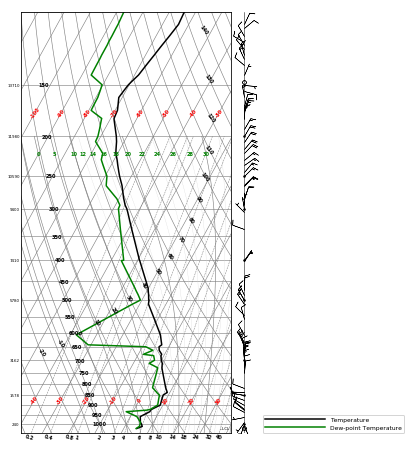

In [121]:
output = '../Soundings_Stavanger/20161219_00Z.pdf'
#skewt.plot(None,z, th, p, qv, u, v, output, title = 'Sounding Data')
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(1, figsize=(6.5875, 6.2125), edgecolor = 'k')

# sounding
ax1 = fig.add_subplot(121)
skewt.plot_sounding_axes(ax1)
# plot Temperature
linecolor_T = skewt.linecolor_T
linewidth_T = skewt.linewidth_T
ax1.semilogy(T + skewt.skew(p),p, basey=math.e, color =linecolor_T, linewidth = linewidth_T)
# plot dewpoint
linecolor_Td = skewt.linecolor_Td
linewidth_Td = skewt.linewidth_Td
ax1.semilogy(Td + skewt.skew(p), p, basey=math.e, color=linecolor_Td, linewidth = linewidth_Td)
# wind barbs
ax4 = fig.add_subplot(132)
skewt.plot_wind_axes(ax4)
skewt.plot_wind_barbs(ax4,z,p,u,v)

# Add labels for levels based on surface parcel
#debug print(pcl['lfcprs'], pcl['lclprs'], pcl['elprs'], pcl['ptops'])
Tmax = 40.
# Get surface parcel CAPE and temperature / height profiles
pcl = thermo.CAPE(z, p, T+thermo.T00, qv, 1)        # CAPE
if (pcl['lfcprs'] > 0):
    skewt.label_m(Tmax-.5, pcl['lfcprs'], '--LFC', ax1)
if (pcl['lclprs'] > 0):
    skewt.label_m(Tmax-.5, pcl['lclprs'], '--LCL', ax1)
if (pcl['elprs'] > 0):
    skewt.label_m(Tmax-.5, pcl['elprs'], '--EL', ax1)
if (pcl['ptops'] > 0):
    skewt.label_m(Tmax-.5, pcl['ptops'], '--TOPS', ax1)
    
# plot labels for std heights
plevs_std = [100000,85000,70000,50000,40000,30000,25000,20000,15000]
for plvl in plevs_std:
    zlvl = interp.interp_height(z,p,plvl)
    skewt.label_m(Tmin-.5,plvl, str(int(zlvl)), ax1)

# plot wind barbs on left side of plot.  move this?  right side?
pt_plot = 10000
Tmin = -40.
if (u is not None and v is not None):
      #draw_wind_line(axes)
        for i in np.arange(0,len(z),2):
            if (p[i] > pt_plot):
                plt.barbs(Tmin+4,p[i],u[i],v[i], length=5, linewidth=.5)
                
# legend
ax5 = fig.add_subplot(4,4,15)
tT = r'Temperature'
lT = Line2D(range(10), range(10), linestyle='-', marker='', linewidth=linewidth_T, color=linecolor_T)

tTd = r'Dew-point Temperature'
lTd = Line2D(range(10), range(10), linestyle='-', marker='', linewidth=linewidth_Td, color=linecolor_Td)

plt.legend((lT, lTd,),(tT, tTd, ),
             loc=(0.125,0), fontsize=6, handlelength=10)
# loc =, frameon=, fontsize=
ax5.set_axis_off()

# Adjust plot margins.
plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97, wspace=0.12, hspace=0.12)
output = '../Soundings_Stavanger/20161219_00Z.png'
plt.savefig(output)#, dpi=300,bbox_inches=0)
#plt.close()

